In [1]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 150

In [3]:
class RBFJump(RBF):
    R"""An RBF Kernel that creates draws with a jump discontinuity in the function and all of its derivatives.
    
    See Scikit learn documentation for info on the original RBF kernel.
    The interesting new parameter is jump, which must have the same dimension as length_scale.
    This is the location of the jump, and the space with X < jump will be separated from X > jump.
    Thus, if dimension i has no jump, then one must set `jump[i] = np.inf`.
    """
    
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5), jump=1.0):
        super().__init__(length_scale=length_scale, length_scale_bounds=length_scale_bounds)
        self.jump = jump
        
    def __call__(self, X, Y=None, eval_gradient=False):
        if eval_gradient:
            raise ValueError('gradients not implemented for jump kernel yet')
        K = super().__call__(X, Y=Y, eval_gradient=eval_gradient)
        if Y is None:
            Y = X
        mask_X = np.any(X > self.jump, axis=1)
        mask_Y = np.any(Y > self.jump, axis=1)
        # We want to find all pairs (x, x') where one is > jump and the other is < jump.
        # These points should be uncorrelated with one another.
        # We can use the XOR (exclusive or) operator to find all such pairs.
        zeros_mask = mask_X[:, None] ^ mask_Y
        K[zeros_mask] = 0.
        return K

# 1D Case

First let's generate a curve that has a discontinuity at some location

In [4]:
x = np.linspace(0, 2, 100)
X = x[:, None]
ell_true = 0.2

kernel = RBFJump(length_scale=ell_true, jump=1.) + WhiteKernel(1e-5, noise_level_bounds='fixed')
K = kernel(X)
np.random.seed(1)
y = stats.multivariate_normal(cov=K).rvs(1)

In [5]:
x_train = x[::5]
X_train = X[::5]
y_train = y[::5]

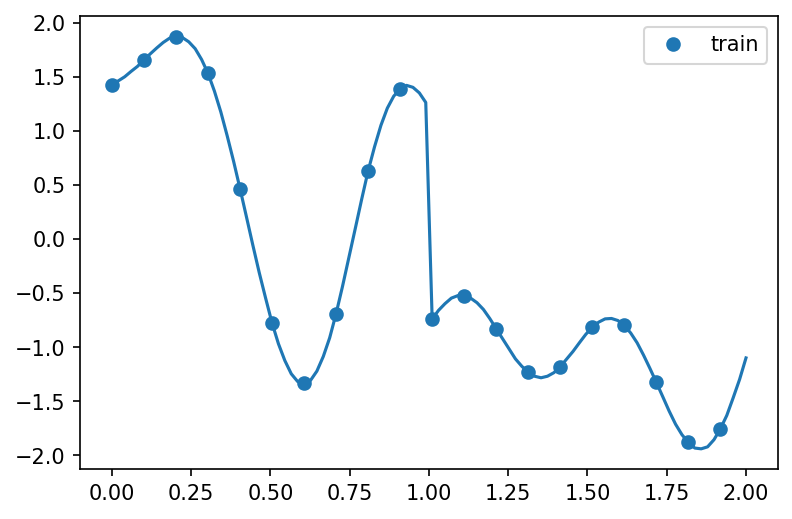

In [6]:
plt.plot(x, y)
plt.plot(x_train, y_train, ls='', marker='o', c='C0', label='train')
plt.legend();

## Length scale estimation (Bad)

Cool, now what if we found the posterior for the length scale assuming that there is no jump? I.e., it is just a vanilla draw from a GP with an RBF kernel.

In [7]:
ell_vals = np.linspace(1e-5, 0.5, 200)
# ell_vals = np.linspace(0.5, 2, 200)

In [8]:
logpdf_rbf = []
ell_vals_rbf = np.linspace(1e-5, 0.5, 200)
kernel_rbf = RBF(length_scale=ell_true) + WhiteKernel(1e-5, noise_level_bounds='fixed')

for ell in ell_vals:
    kern_i = kernel_rbf.clone_with_theta(np.log([ell,]))
    K_i = kern_i(X_train)
    logpdf_rbf.append(stats.multivariate_normal(cov=K_i).logpdf(y_train))
    
logpdf_rbf = np.array(logpdf_rbf)
ell_pdf_rbf = np.exp(logpdf_rbf - np.max(logpdf_rbf))

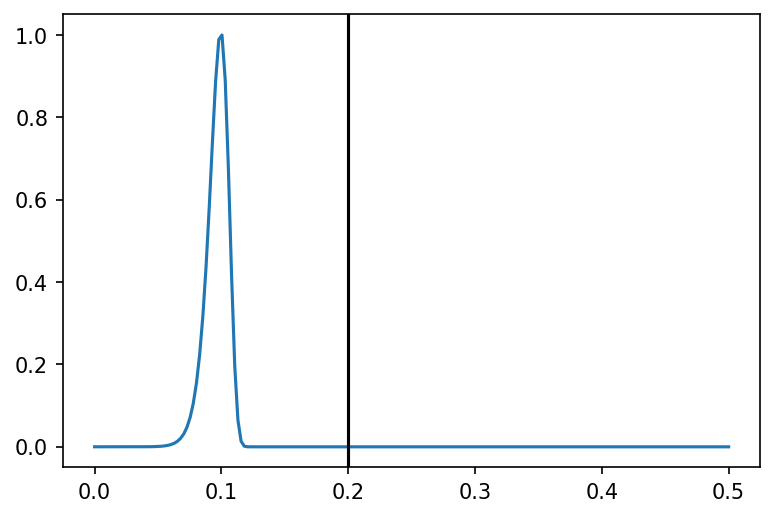

In [9]:
plt.plot(ell_vals, ell_pdf_rbf)
plt.axvline(ell_true, 0, 1, color='k');

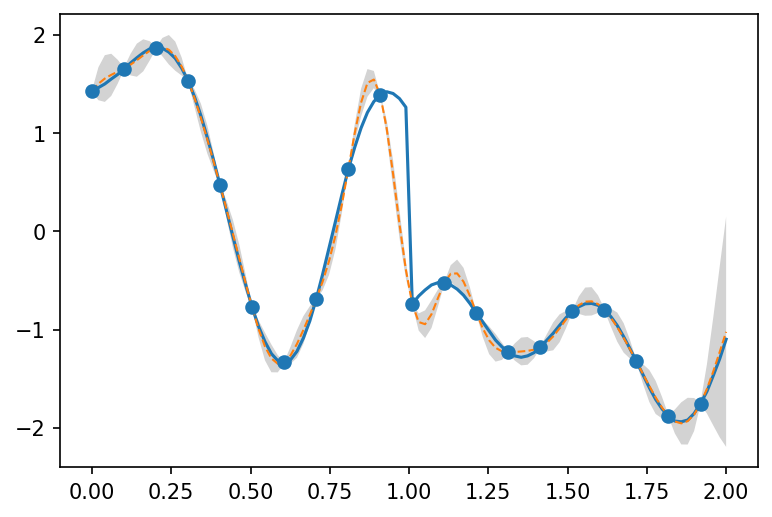

In [10]:
ell_map_bad = ell_vals[np.argmax(ell_pdf_rbf)]
gp_bad = GaussianProcessRegressor(
    kernel=kernel_rbf.clone_with_theta(np.log([ell_map_bad])), optimizer=None
)
gp_bad.fit(X_train, y_train)
y_pred_bad, std_pred_bad = gp_bad.predict(X, return_std=True)

plt.plot(x, y)
plt.plot(x, y_pred_bad, ls='--', lw=1)
plt.fill_between(x, y_pred_bad+2*std_pred_bad, y_pred_bad-2*std_pred_bad, facecolor='lightgray')
plt.plot(x_train, y_train, ls='', marker='o', c='C0', label='train');

Not good. The length scale is drawn downwards by the sharp jump.

## Length scale estimation (Good)

Now let's treat it as if the lower half is uncorrelated with the upper half (but they share the same length scale).

In [11]:
logpdf = []

for ell in ell_vals:
    kern_i = kernel.clone_with_theta(np.log([ell,]))
    K_i = kern_i(X_train)
    logpdf.append(stats.multivariate_normal(cov=K_i).logpdf(y_train))
    
logpdf = np.array(logpdf)
ell_pdf = np.exp(logpdf - np.max(logpdf))

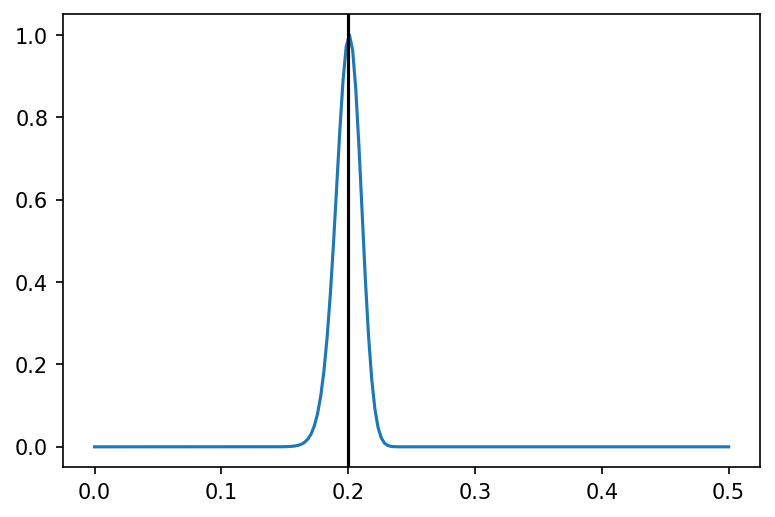

In [12]:
plt.plot(ell_vals, ell_pdf)
plt.axvline(ell_true, 0, 1, color='k');

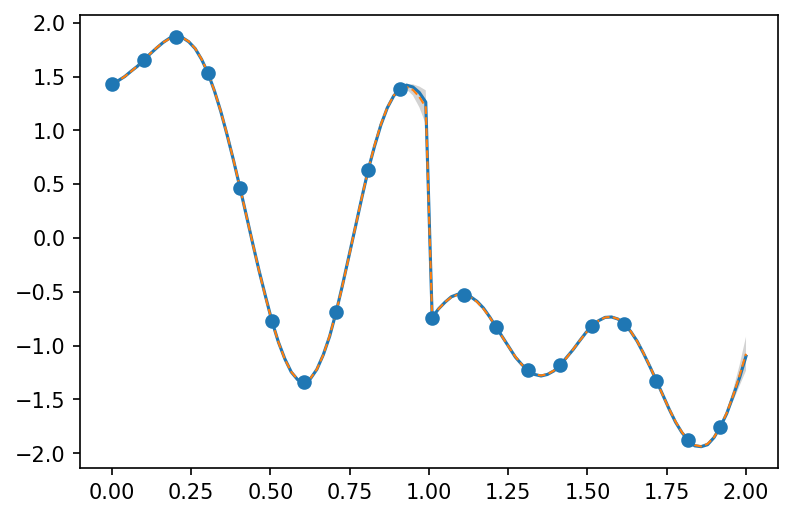

In [13]:
ell_map_good = ell_vals[np.argmax(ell_pdf)]
gp_good = GaussianProcessRegressor(
    kernel=kernel.clone_with_theta(np.log([ell_map_good])), optimizer=None
)
gp_good.fit(X_train, y_train)
y_pred_good, std_pred_good = gp_good.predict(X, return_std=True)

plt.plot(x, y)
plt.plot(x, y_pred_good, ls='--', lw=1)
plt.fill_between(x, y_pred_good+2*std_pred_good, y_pred_good-2*std_pred_good, facecolor='lightgray')
plt.plot(x_train, y_train, ls='', marker='o', c='C0', label='train');

Wow!

# 2D Case

Why not?

In [14]:
def cartesian(*arrays):
    """Makes the Cartesian product of arrays.

    Parameters
    ----------
    *arrays : array group, shapes = (N_1,), (N_2,), ..., (N_p,)
            1D arrays where earlier arrays loop more slowly than later ones
    Returns
    -------
    array, shape = (N_1 * N_2 * ... * N_p, p)
        The cartesian product
    """
    N = len(arrays)
    return np.stack(np.meshgrid(*arrays, indexing='ij'), -1).reshape(-1, N)

In [15]:
N1 = 40
N2 = 50
x_dim1 = np.linspace(0, 1, N1)
x_dim2 = np.linspace(0, 2, N2)
X2 = cartesian(x_dim1, x_dim2)
ell_dim1_true = 0.2
ell_dim2_true = 0.5
ell2_true = np.array([ell_dim1_true, ell_dim2_true])
jump2 = np.array([0.5, np.inf])

kernel = RBFJump(length_scale=ell2_true, jump=jump2) + WhiteKernel(1e-5, noise_level_bounds='fixed')
K2 = kernel(X2)
np.random.seed(2)
y2 = stats.multivariate_normal(cov=K2).rvs(1)
y2_mat = y2.reshape(N1, N2).T  # N2 x N1

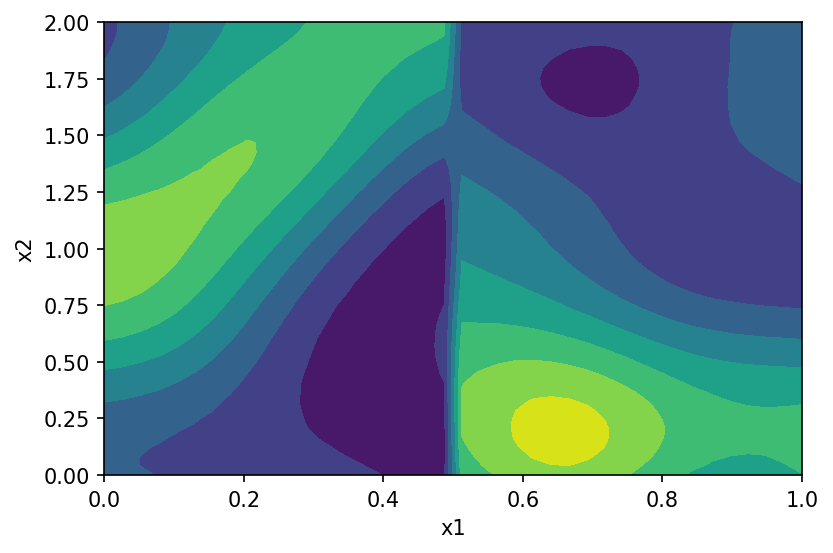

In [16]:
plt.contourf(x_dim1, x_dim2, y2_mat)
plt.xlabel('x1')
plt.ylabel('x2');

Space out the training points

In [17]:
X2_train = X2[::10]
y2_train = y2[::10]

In [18]:
logpdf2 = []
ell_dim1_vals = np.linspace(1e-5, 0.5, 30)
ell_dim2_vals = np.linspace(0.2, 1, 30)
ell_vals2 = cartesian(ell_dim1_vals, ell_dim2_vals)

for ell in ell_vals2:
    kern_i = kernel.clone_with_theta(np.log(ell))
    K_i = kern_i(X2_train)
    logpdf2.append(stats.multivariate_normal(cov=K_i).logpdf(y2_train))
    
logpdf2 = np.array(logpdf2)
ell_pdf2 = np.exp(logpdf2 - np.max(logpdf2))
ell_pdf2_mat = ell_pdf2.reshape(len(ell_dim1_vals), len(ell_dim2_vals)).T
ell_logpdf2_mat = logpdf2.reshape(len(ell_dim1_vals), len(ell_dim2_vals)).T

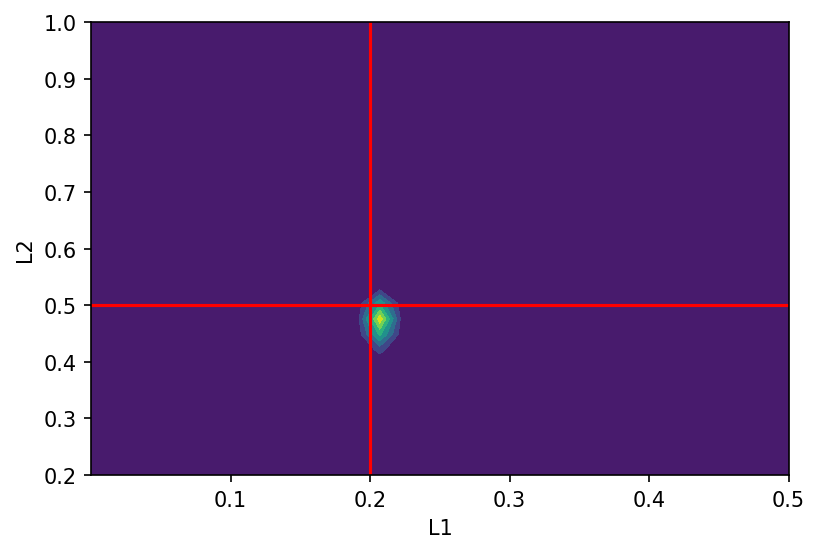

In [19]:
plt.contourf(ell_dim1_vals, ell_dim2_vals, ell_pdf2_mat)
plt.axhline(ell_dim2_true, 0, 1, c='r')
plt.axvline(ell_dim1_true, 0, 1, c='r')
plt.xlabel('L1')
plt.ylabel('L2');

Okay, now that's just cool.